In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from utility import bin_cell

In [3]:
# sns.reset_defaults()

In [4]:
import os
from os.path import join as opj

In [5]:
import healpy as hp
import numpy as np

In [6]:
# Finally, synfast will build a realization of the lensed maps for you from scratch
from lenspyx import synfast
from lenspyx.utils import camb_clfile

In [7]:
import plancklens
from plancklens.filt import filt_simple, filt_util
from plancklens import utils
from plancklens import qest, qecl, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.sims import planck2018_sims, phas, maps, utils as maps_utils

from plancklens.utils import clhash, hash_check

In [8]:
import pysm3 
import pysm3.units as u

In [9]:
from common import convert_units

In [10]:
from plancklens import nhl
from plancklens.n1 import n1

In [11]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

In [12]:
from shutil import rmtree

In [34]:
12*4096**2*8/(1024**3)

1.5

# simulation class

In [84]:
class cmb_len(object):

    def __init__(self, add_foreground = False):
        
        if add_foreground is not False:
            self.add_foreground = add_foreground
        
        elif add_foreground is False:
            self.add_foreground = 'no_fore'
        
        # self.dirs = os.environ["data"] + 'cmb_plus_%s'%self.add_foreground
        
    def hashdict(self):
        return {'sim_lib': 'ffp10 lensed scalar cmb inputs, freq 0'}

    # @staticmethod
    def get_sim_tlm(self, idx):
        
        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=1)
        
        if add_foreground != 'no_fore':
            alms = os.environ['data'] + 'CMB_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, idx)
        
        elif add_foreground == 'no_fore':
            alms = os.environ['data'] + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024_%04d.fits'%(add_foreground, idx)
        return hp.read_alm(alms, hdu = 1)
    
    # @staticmethod
    def get_sim_elm(self, idx):

        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=2)
        
        if add_foreground != 'no_fore':
            alms = os.environ['data'] + 'CMB_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, idx)
        
        elif add_foreground == 'no_fore':
            alms = os.environ['data'] + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024_%04d.fits'%(add_foreground, idx)
        return hp.read_alm(alms, hdu = 2)

    # @staticmethod
    def get_sim_blm(self, idx):

        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=3)
        
        if add_foreground != 'no_fore':
            alms = os.environ['data'] + 'CMB_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, idx)
        
        elif add_foreground == 'no_fore':
            alms = os.environ['data'] + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024_%04d.fits'%(add_foreground, idx)
        return hp.read_alm(alms, hdu = 3)
    
    
class cmb_noise(object):
    r"""CMB simulation library combining a lensed CMB library and a transfer function.

        Args:
            sims_cmb_len: lensed CMB library (e.g. *plancklens.sims.planck2018_sims.cmb_len_ffp10*)
            cl_transf: CMB temperature transfer function
            nside: healpy resolution of the maps. Defaults to 2048.
            lib_dir(optional): hash checks will be cached, as well as possibly other things for subclasses.
            cl_transf_P: CMB pol transfer function (if different from cl_transf)\
            eff_beam: fwhm; None or a number; if a number, apply the beam of this level to the input cleaned CMB map

    """
    def __init__(self, sims_cmb_len, cl_transf, nlev_t, nlev_p, nside=2048, cl_transf_P=None, lib_dir=None):
        if cl_transf_P is None:
            cl_transf_P = np.copy(cl_transf)

        self.sims_cmb_len = sims_cmb_len
        self.cl_transf_T = cl_transf
        self.cl_transf_P = cl_transf_P
        self.nside = nside
        self.nlev_t = nlev_t
        self.nlev_p = nlev_p
        self.vamin = np.sqrt(hp.nside2pixarea(self.nside, degrees=True)) * 60

        if lib_dir is not None:
            fn_hash = os.path.join(lib_dir, 'sim_hash.pk')
            if mpi.rank == 0 and not os.path.exists(fn_hash):
                pk.dump(self.hashdict(), open(fn_hash, 'wb'), protocol=2)
            mpi.barrier()
            hash_check(self.hashdict(), pk.load(open(fn_hash, 'rb')), fn=fn_hash)

    def hashdict(self):
        ret = {'sims_cmb_len':self.sims_cmb_len.hashdict(),'nside':self.nside,'cl_transf':clhash(self.cl_transf_T)}
        if not (np.all(self.cl_transf_P == self.cl_transf_T)):
            ret['cl_transf_P'] = clhash(self.cl_transf_P)
        return ret

    def get_sim_tmap(self,idx):
        """Returns temperature healpy map for a simulation

            Args:
                idx: simulation index

            Returns:
                healpy map

        """
        tlm = self.sims_cmb_len.get_sim_tlm(idx)
        # hp.almxfl(tlm,self.cl_transf_T,inplace=True)
        tmap = hp.alm2map(tlm,self.nside)
        return tmap + self.get_sim_tnoise(idx)

    def get_sim_pmap(self,idx):
        """Returns polarization healpy maps for a simulation

            Args:
                idx: simulation index

            Returns:
                Q and U healpy maps

        """
        elm = self.sims_cmb_len.get_sim_elm(idx)
        blm = self.sims_cmb_len.get_sim_blm(idx)
        
        if self.cl_transf_T[-1] != 1:
            # in the case of apply the effective beam to the input cleaned CMB map
            hp.almxfl(elm,self.cl_transf_P,inplace=True)
            hp.almxfl(blm, self.cl_transf_P, inplace=True)
        Q,U = hp.alm2map_spin([elm,blm], self.nside, 2,hp.Alm.getlmax(elm.size))
        del elm,blm
        return Q + self.get_sim_qnoise(idx),U + self.get_sim_unoise(idx)

    def get_sim_tnoise(self,idx):
        '''
        there are already noise in the clean CMB maps
        '''
        return 0 #self.nlev_t / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[0] # one frequency for now 11.15

    def get_sim_qnoise(self, idx):
        
        return 0 #self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[1]

    def get_sim_unoise(self, idx):
        
        return 0 #self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[2]

## generating maps

In [271]:
def gen_noise_map(nlep, nside, N):
    
    '''
    nlep: noise level for each frequency band
    '''
    depth_p =np.array(nlep)
    depth_i = depth_p/np.sqrt(2)
    pix_amin2 = 4. * np.pi / float(hp.nside2npix(nside)) * (180. * 60. / np.pi) ** 2
    """sigma_pix_I/P is std of noise per pixel. It is an array of length
    equal to the number of input maps."""
    sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
    sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
    npix = hp.nside2npix(nside)
    
    for i in range(N):
        noise = np.random.randn(len(depth_i), 3, npix) # first dimension is the index of frequency band
        noise[:, 0, :] *= sigma_pix_I[:, None]
        noise[:, 1, :] *= sigma_pix_P[:, None]
        noise[:, 2, :] *= sigma_pix_P[:, None]
        
        np.save(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%i), noise[0]) # one frequency for now 11.15

def gen_cmb_len_alm(nside, N, fwhm = None, add_foreground = False):
    
    '''
    simulte sky at one frequency, return one realization of unlensed CMB map and lensed CMB map with the beam applied
    '''
    
    cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
    geom_info = ('healpix', {'nside':nside}) # Geometry parametrized as above, this is the default
    
    for i in range(N):
        maps = synfast(cl_unl, lmax=lmax_unl, verbose=1, geometry=geom_info, alm = True)
        # Generations of the unlensed alms will include all correlations as given in the cl_unl dictionary
        # Feed-in alm=True to return the unlensed alm as well

        cmb_len = np.row_stack((maps[0]['T'], maps[0]['QU']))
        # cmb_len = hp.smoothing(cmb_len, fwhm = fwhm)
        # cmb_unl = hp.alm2map(maps[1][0], nside = NSIDE, fwhm = fwhm)
        
        if add_foreground == 'd0':
            sky = pysm3.Sky(nside=nside, preset_strings=["d0"])
            map_100GHz = sky.get_emission(100 * u.GHz)
            map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))
            
            map_100GHz = map_100GHz.value + cmb_len
            alms = hp.map2alm(map_100GHz)
            
        elif add_foreground == 'forse3':
            
            map_100GHz = np.zeros((3, 12*nside**2))
            
            forse_Q = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/forse_dust_Q_100GHz_3amin_nside4096_uK_RJ.fits')*convert_units('uK_RJ', 'uK_CMB', 100)
            forse_U = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/forse_dust_U_100GHz_3amin_nside4096_uK_RJ.fits')*convert_units('uK_RJ', 'uK_CMB', 100)
            
            map_100GHz[1] = pysm3.apply_smoothing_and_coord_transform(forse_Q, output_nside=nside)
            map_100GHz[2] = pysm3.apply_smoothing_and_coord_transform(forse_U, output_nside=nside)
            
            map_100GHz = map_100GHz + cmb_len
            alms = hp.map2alm(map_100GHz)         
            
        elif add_foreground is False:
            
            add_foreground = 'no_fore'
            alms = hp.map2alm(cmb_len)        
    
        # for fwhm, alm in zip(fwhms, alms):
        transf = hp.gauss_beam(np.radians(fwhm/60.0), lmax = 3*nside - 1) * hp.pixwin(nside,lmax = 3*nside - 1)
        for j in range(3): # T, E, B
            hp.almxfl(alms[j], transf, inplace=True)
                
        dirs = os.environ["data"] + 'cmb_plus_%s'%add_foreground
        if not os.path.exists(dirs):
            os.makedirs(dirs)

        hp.write_alm(opj(dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(add_foreground, i)), alms, overwrite=True)

In [274]:
# gen_noise_map(nlep=[1.0,], nside=nside, N = 1)

add_foreground = 'forse3' # 'd0'|'forse3'|False

# gen_cmb_len_alm(nside=nside, N = 1, fwhm = 4.0, add_foreground='d0')
gen_cmb_len_alm(nside=nside, N = 1, fwhm = 4.0, add_foreground=add_foreground)

  cl matrix        :  [0:00:00.016568] (0.4%)  
  phases generation:  [0:00:00.506188] (12.3%)  
  alms from phases :  [0:00:00.676243] (16.4%)  
  alm2lenmap       :  [0:00:02.885179] (70.1%)  
  Total            :  [0:00:04.113726] d:h:m:s:mus


In [218]:
gen_cmb_len_alm(nside=nside, N = 1, fwhm = 4.0, add_foreground=False)

  cl matrix        :  [0:00:00.018380] (0.4%)  
  phases generation:  [0:00:00.544322] (12.7%)  
  alms from phases :  [0:00:00.731482] (17.1%)  
  alm2lenmap       :  [0:00:02.944040] (68.9%)  
  Total            :  [0:00:04.272438] d:h:m:s:mus


# apply plancklens

In [14]:
# lmax_len = 2048# desired lmax of the lensed field.
# dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
# epsilon = 1e-6 # target accuracy of the output maps (execution time has a fairly weak dependence on this)
# lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax

In [14]:
#--- definition of simulation and inverse-variance filtered simulation libraries:
lmax_ivf = 2048
lmin_ivf = 100  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 2048 # We will calculate lensing estimates until multipole lmax_qlm.; 4096
nside = 1024 # Healpix resolution of the data and sims.; 2048

nsims = 300  # Total number of simulations to consider.

In [81]:
cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
#: Fiducial unlensed and lensed power spectra used for the analysis.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.
#: CMB spectra entering the QE weights (the spectra multplying the inverse-variance filtered maps in the QE legs) 

In [82]:
# os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/' # one frequency
os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT/' # SO LAT
# os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'

Caching sky fractions...
 [00:27:07] calculating peb MF ---------> 99%
Cached  /pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/cleaned_cmb_d9_eff_bl/qlms_dd/simMF_k1peb_e6450bce0728e9ad962f344130db44d5d9898ed7.fits
 [00:22:40] calculating pbe MF ---------> 99%
Cached  /pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/cleaned_cmb_d9_eff_bl/qlms_dd/simMF_k1pbe_e6450bce0728e9ad962f344130db44d5d9898ed7.fits


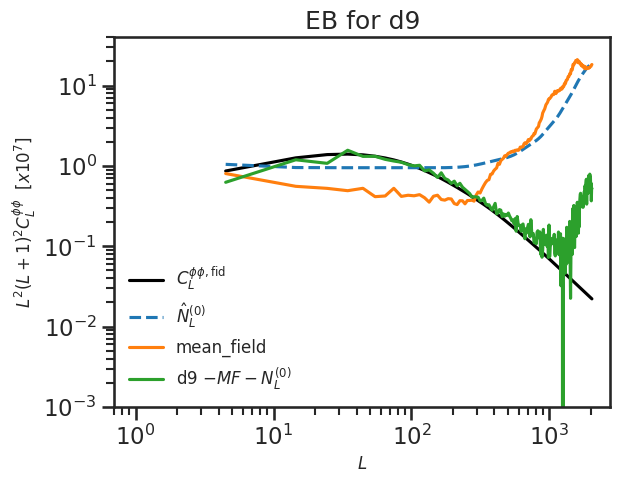

In [85]:
# cases = ['d0', 'd1', 'forse3_d0', 'forse3_d1']
# cases = ['forse3_d0']
# cases = ['d9', 'd10', 'forse3_d9', 'forse3_d10','forse3_Gaussiand10', 'forse3_Gaussiand1', 'forse3_d0', 'forse3_d1']
# cases = ['forse3_d0']
# cases = ['forse3_Gaussiand9']
# cases = ['d9', 'd10', 'forse3_d9', 'forse3_d10', 'forse3_Gaussiand9','forse3_Gaussiand10']
# cases = ['no_fore', 'forse3_Gaussiand9', 'd9', 'forse3_d9']
# cases = ['no_fore']
cases = ['d9']
# results_phi = []
# results_n0 = []
# results_mf = []

results_phi_unbinned = []
results_n0_unbinned = []
results_mf_unbinned = []


# transf = hp.gauss_beam(np.radians(1.4/60), lmax=lmax_ivf)#*hp.pixwin(nside)[:lmax_ivf + 1] # maps are already deconvolved during component separation, before the lensing reconstruction
transf = np.ones(lmax_ivf + 1)
# transf = hp.gauss_beam(np.radians(2.15/60), lmax=lmax_ivf)
# transf = hp.pixwin(nside, lmax = lmax_ivf)

for add_foreground in cases:
    
    # plt.loglog(nl[2])
    
    nlev_t = 0; #2.16
    nlev_p = 0; #2.16
    qnorms = []
    nhl_datas = []
    qlms = []  

    if add_foreground != 'no_fore':
        os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT/' # SO LAT
        nl_all = []
        for mc in range(100):
            noise_alm = hp.read_alm(os.environ['data'] + 'Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), hdu = [1, 2, 3])
            nl_all.append(hp.alm2cl(noise_alm, lmax =  lmax_ivf))
        nl_mean = np.mean(nl_all, axis = 0)
        # print(nl_mean.shape)

        ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + nl_mean[0]/transf**2) #(nlev_t / 60. / 180. * np.pi / transf) ** 2) # covariance 
        fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + nl_mean[1]/transf**2) #(nlev_p / 60. / 180. * np.pi / transf) ** 2)
        fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + nl_mean[2]/transf**2) #(nlev_p / 60. / 180. * np.pi / transf) ** 2)
        
        TEMP = '/pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/cleaned_cmb_%s_eff_bl'%add_foreground
        
    elif add_foreground == 'no_fore':
        os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'
        nlev_t = 10.0; nlev_p = 14.1; # for the case of SO_LAT 145GHz
        ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2) # covariance 
        fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
        fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
        
        TEMP = '/pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/no_fore/' 

    ftl[:lmin_ivf] *= 0.
    fel[:lmin_ivf] *= 0.
    fbl[:lmin_ivf] *= 0.
    #: Inverse CMB co-variance in T, E and B (neglecting TE coupling).
        
    # try:
    #     rmtree(TEMP)
    # except:
    #     print('Not Exist')
    #     pass
    
    sims = cmb_noise(cmb_len(add_foreground=add_foreground), transf, nlev_t, nlev_p, nside)

    ivfs = filt_simple.library_fullsky_sepTP(os.path.join(TEMP, 'ivfs'), sims, nside, transf, cl_len, ftl, fel, fbl, cache=True)
    #: Inverse-variance filtering instance. Here a trivial isotropic inverse variance weighting.

    #---- QE libraries instances. For the MCN0, RDN0, MC-correction etc calculation, we need in general three of them,
    qlms_dd = qest.library_sepTP(os.path.join(TEMP, 'qlms_dd'), ivfs, ivfs,   cl_len['te'], nside, lmax_qlm=lmax_qlm)

    #---- semi-analytical Gaussian lensing bias library:
    nhl_dd = nhl.nhl_lib_simple(os.path.join(TEMP, 'nhl_dd'), ivfs, cl_weight, lmax_qlm)

    #---- N1 lensing bias library:
    # libdir_n1_dd = os.path.join(TEMP, 'n1_test')
    # n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

    #---- QE response calculation library:
    qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cl_weight, cl_len,
                                     {'t': ivfs.get_ftl(), 'e':ivfs.get_fel(), 'b':ivfs.get_fbl()}, lmax_qlm)
        
    for mc in range(1):
        
        for qe_key in ['p_eb']:
        #     # This loads the estimate calculated in the previous cell:
            qlm = qlms_dd.get_sim_qlm(qe_key, mc)

            # Lensing response according to the fiducial cosmology:
            qresp_dat = qresp_dd.get_response(qe_key, 'p')

            # Estimator normalization is the inverse response:
            qnorm = utils.cli(qresp_dat)

        #     # Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
            nhl_data = nhl_dd.get_sim_nhl(mc, qe_key, qe_key)

            qlms.append(qlm)
            qnorms.append(qnorm)
            nhl_datas.append(nhl_data)
            
    bw = 10
    ell_binned, cl_pp = bin_cell(cl_unl['pp'][ell] *  w(ell), lmax = lmax_ivf, bin_width=bw, ell_2=False)
    _, n0_binned =  bin_cell(nhl_data[ell] * qnorm[ell] ** 2 * w(ell), lmax = lmax_ivf, bin_width=bw, ell_2=False)

    # qlm_mean = np.mean(qlms[1:], axis = 0)
    
    # ## check Gaussian!!!
    # qlm_mean = 0
    # qlms_mf_300 = 0
    qlms_mf_300 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 300))

    _, cleaned =  bin_cell((hp.alm2cl(qlms[0] - qlms_mf_300)[ell] - nhl_data[ell])* qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), lmax = lmax_ivf, bin_width=bw, ell_2=False)

    plt.figure()
    plt.title('EB for %s'%add_foreground)
    label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 2, 2048) # qnorms has very large number for \ell = 1; 2023/12/26
    
    plt.loglog(ell_binned, cl_pp[0], c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    plt.loglog(ell_binned, n0_binned[0], '--', label=r'$\hat N_L^{(0)}$')
    
    if np.mean(qlms_mf_300) == 0:
        plt.loglog(ell_binned, cleaned[0], label = r'%s $- N_L^{(0)}$'%add_foreground)
        
    else:
        _, mf_binned =  bin_cell(hp.alm2cl(qlms_mf_300)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), lmax = lmax_ivf, bin_width=bw, ell_2=False)
        plt.loglog(ell_binned, mf_binned[0], label = 'mean_field')
        plt.loglog(ell_binned, cleaned[0], label = r'%s $- MF - N_L^{(0)}$'%add_foreground)
    plt.xlabel('$L$', fontsize=12)
    plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
    plt.ylim(1e-3,4e1)
    plt.xlim(0.7, )
    plt.legend(fontsize=12, loc='lower left', frameon = False)
    
    # results_phi.append(cleaned[0])
    # results_mf.append(mf_binned[0])
    # results_n0.append(n0_binned[0])
    
#     results_phi_unbinned.append((hp.alm2cl(qlms[0] - qlms_mf_300)[ell] - nhl_data[ell])* qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell))
#     results_n0_unbinned.append(nhl_data[ell] * qnorm[ell] ** 2 * w(ell))
#     results_mf_unbinned.append(hp.alm2cl(qlms_mf_300)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell))
# #     plt.figure()
#     phi_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/phi_alms/'            
#     phi_name = phi_dir + 'phi_%04d.fits'%mc
#     input_qlm = hp.read_alm(phi_name)
#     qlm_map = hp.alm2map(input_qlm, nside)
#     input_qlm = hp.map2alm(qlm_map, lmax_qlm)

#     qlm_norm = hp.almxfl(qlms[mc], qnorm)
#     cross_corre = hp.alm2cl(qlm_norm, input_qlm)/np.sqrt(hp.alm2cl(qlm_norm)*hp.alm2cl(input_qlm))
#     ell_cross, cross_binned = bin_cell(cross_corre, bin_width=10, lmax = lmax_qlm, ell_2 = False)
#     plt.plot(ell_cross, cross_binned[0])
#     plt.title('correlation of case %s'%add_foreground)

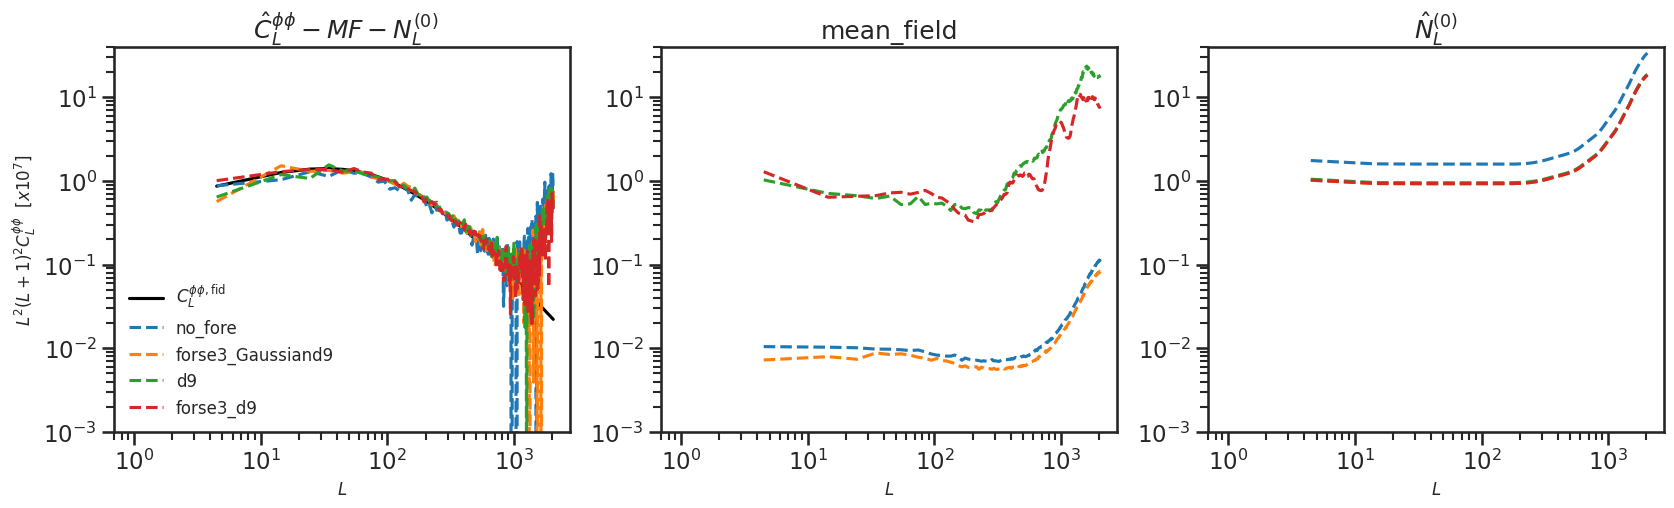

In [40]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
# plt.title('EB for %s'%add_foreground)
label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
ell = np.arange(2 if qe_key[0] == 'x' else 2, 2048) # qnorms has very large number for \ell = 1; 2023/12/26

axes[0].loglog(ell_binned, cl_pp[0], c='k', label=r'$C_L^{\phi\phi, \rm fid}$')

results_all = [results_phi, results_mf, results_n0]
titles = [r' $ \hat{C}_L^{\phi\phi} - MF - N_L^{(0)}$', 'mean_field', r'$\hat N_L^{(0)}$', ]
for i in range(3):
    axes[i].set_title('%s'%titles[i])
    for j in range(len(cases)):

        axes[i].loglog(ell_binned, results_all[i][j], '--', label= '%s'%cases[j])

        if j == 3:
            axes[i].set_xlabel('$L$', fontsize=12)
            axes[i].set_ylim(1e-3,4e1)
            axes[i].set_xlim(0.7, )
    if i == 0:
        axes[i].set_ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
        axes[i].legend(fontsize=12, loc='lower left', frameon = False)

In [69]:
np.savez('anto_results_binned.npz', ells = ell_binned, phi = results_phi, mf = results_mf, n0 = results_n0)

In [74]:
np.savez('anto_results_unbinned.npz', ells =ell, phi = results_phi_unbinned, mf = results_mf_unbinned, n0 = results_n0_unbinned)

In [75]:
cases

['no_fore', 'forse3_Gaussiand9', 'd9', 'forse3_d9']

In [76]:
test = np.load('anto_results_binned.npz')

In [78]:
test['ells'].shape

(204,)

In [79]:
test['phi'].shape

(4, 204)

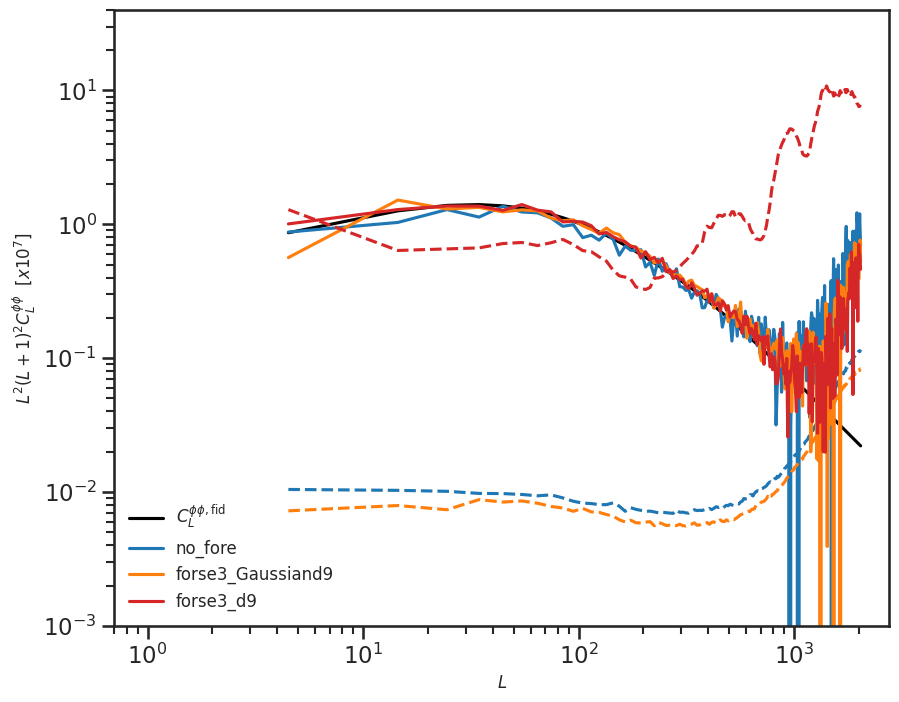

In [49]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# fig, axes = plt.subplots(1, 3, figsize = (20, 5))
plt.figure(figsize = (10, 8))
# plt.title('EB for %s'%add_foreground)
label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
ell = np.arange(2 if qe_key[0] == 'x' else 2, 2048) # qnorms has very large number for \ell = 1; 2023/12/26

plt.loglog(ell_binned, cl_pp[0], c='k', label=r'$C_L^{\phi\phi, \rm fid}$')

results_all = [results_phi, results_mf, results_n0]
titles = [r' $ \hat{C}_L^{\phi\phi} - MF - N_L^{(0)}$', 'mean_field', r'$\hat N_L^{(0)}$', ]
for i in range(1):
    # plt.title('%s'%titles[i])
    for j in [0, 1, 3]:
    
        plt.loglog(ell_binned, results_phi[j], '-', label= '%s'%cases[j], color = colors[j])
        plt.loglog(ell_binned, results_mf[j], '--', color = colors[j])
        if j == 3:
            plt.xlabel('$L$', fontsize=12)
            plt.ylim(1e-3,4e1)
            plt.xlim(0.7, )
    if i == 0:
        plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
        plt.legend(fontsize=12, loc='lower left', frameon = False)

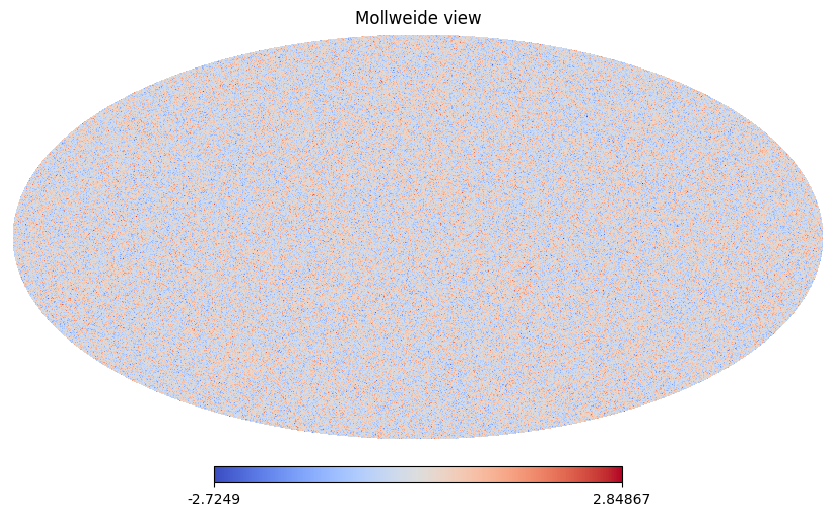

In [95]:
data_dir = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT/'
for i in range(1):
#     cl_fg = hp.alm2cl(hp.read_alm(data_dir + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%("forse3_Gaussiand9", i), hdu = 2))
#     cl_fg_f = hp.alm2cl(hp.read_alm(data_dir + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%("forse3_d9", i), hdu = 2))

#     plt.semilogy(cl_fg)
#     plt.semilogy(cl_fg_f, '--')

    map_fg_res = hp.alm2map(hp.read_alm(data_dir + 'FG_i4lc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%("forse3_Gaussiand9", i), hdu = (1,2,3)), nside = 1024)
    hp.mollview(map_fg_res[2])

Text(0.5, 1.0, 'Mean field of different number of realizations')

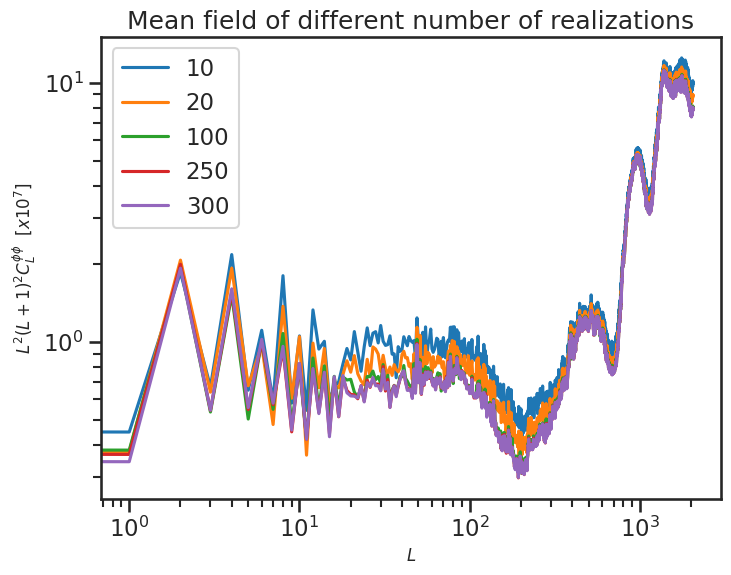

In [21]:
# qlms_mf_10 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 10))
# qlms_mf_20 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 20))
# qlms_mf_100 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 100))
# # qlms_mf_150 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 150))
# # qlms_mf_200 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 200))
# # # _, mf_self = bin_cell(hp.alm2cl(qlms_mf)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), lmax = lmax_ivf, bin_width=bw, ell_2=False)
# qlms_mf_250 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 250))
# qlms_mf_300 = qlms_dd.get_sim_qlm_mf('p_eb', np.arange(1, 300))

plt.figure(figsize = (8, 6))
# # plt.loglog(ell_binned, mf_binned[0], label = 'mf_my')
# # plt.loglog(ell_binned, mf_self[0], label = 'mf_pl')
# # plt.loglog(hp.alm2cl(qlm_mean)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = 'my')
plt.loglog(hp.alm2cl(qlms_mf_10)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '10')
plt.loglog(hp.alm2cl(qlms_mf_20)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '20')
plt.loglog(hp.alm2cl(qlms_mf_100)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '100')
# plt.loglog(hp.alm2cl(qlms_mf_150)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '150')
# plt.loglog(hp.alm2cl(qlms_mf_200)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '200')
plt.loglog(hp.alm2cl(qlms_mf_250)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '250')
plt.loglog(hp.alm2cl(qlms_mf_300)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label = '300')
plt.legend()
# plt.ylim(5e-3, 2)
plt.xlabel('$L$', fontsize=12)
plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
plt.title('Mean field of different number of realizations')

In [154]:
ell

array([   1,    2,    3, ..., 2045, 2046, 2047])

In [157]:
qnorm[ell]**2

array([1.09807013e-04, 1.78522021e-15, 7.14257015e-17, ...,
       1.60079054e-36, 1.59685394e-36, 1.59292748e-36])

In [32]:
(qnorms[0] - qnorms[1]).sum()

0.0

$$ \frac{C_{\ell}^{\hat{\phi}\phi}}{\sqrt{C_{\ell}^{\hat{\phi}\hat{\phi}} C_{\ell}^{\phi\phi}}}$$